In [1]:
# 기본 라이브러리
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리 라이브러리
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# 모델링 라이브러리
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# 오류 방지
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_df = pd.read_csv('data/Train.csv')

# train_df.head()

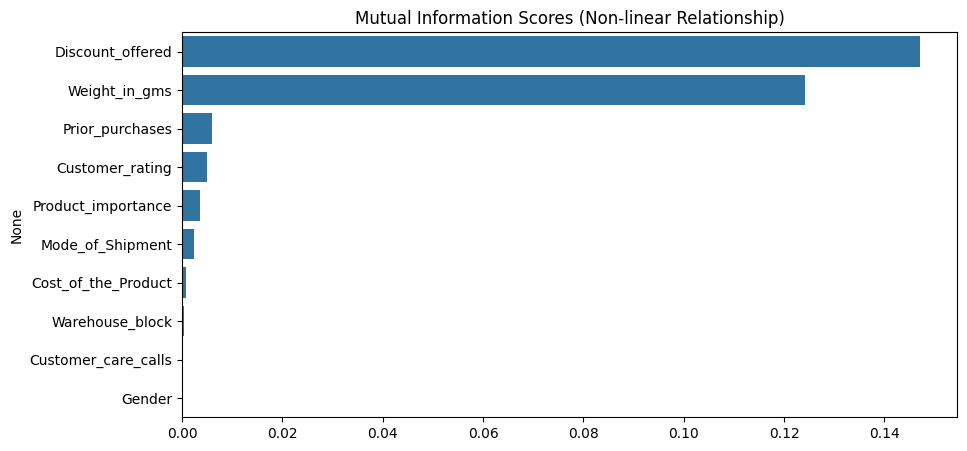

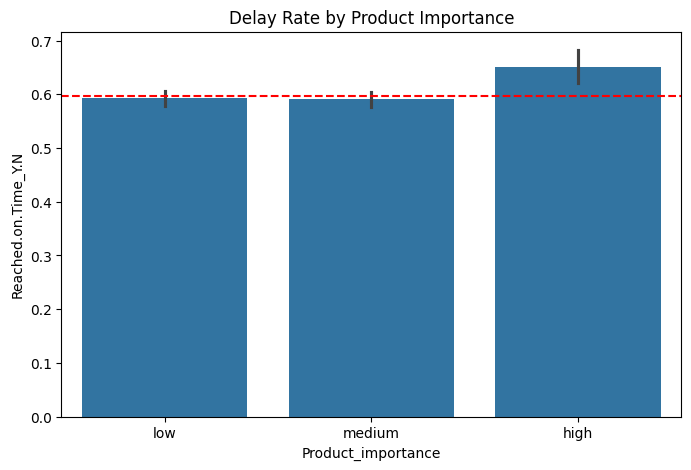

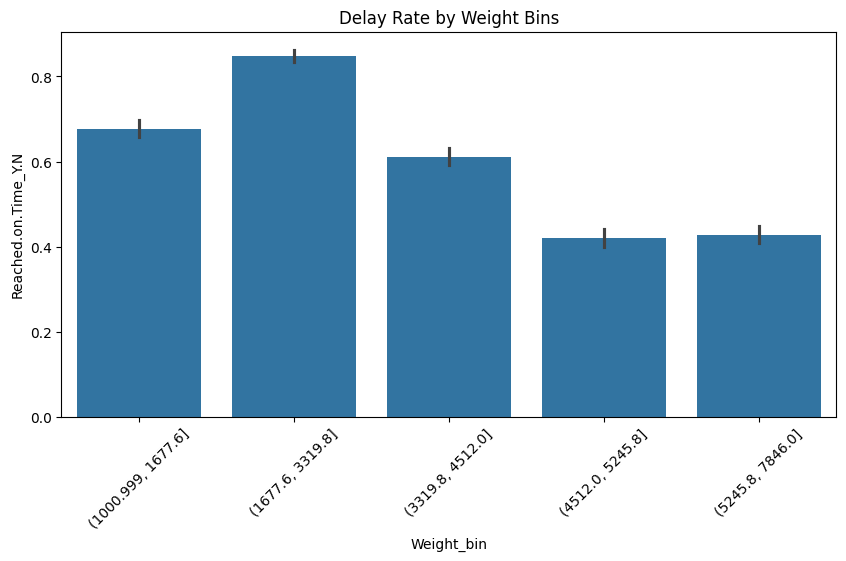

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# 1. 상호정보량 (Mutual Information) 계산
# 범주형 변수를 임시로 인코딩하여 전체적인 의존성을 확인합니다.
train_df_mi = train_df.copy().drop(['ID'], axis=1)
le = LabelEncoder()
for col in train_df_mi.select_dtypes(include='object').columns:
    train_df_mi[col] = le.fit_transform(train_df_mi[col])

X = train_df_mi.drop('Reached.on.Time_Y.N', axis=1)
y = train_df_mi['Reached.on.Time_Y.N']

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_results = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)

# 2. 시각화: 상호정보량 순위
plt.figure(figsize=(10, 5))
sns.barplot(x=mi_results.values, y=mi_results.index)
plt.title("Mutual Information Scores (Non-linear Relationship)")
plt.show()

# 3. 중요 범주형 변수 분석 (Product_importance vs 지연율)
plt.figure(figsize=(8, 5))
sns.barplot(x='Product_importance', y='Reached.on.Time_Y.N', data=train_df)
plt.title("Delay Rate by Product Importance")
plt.axhline(train_df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--') # 전체 평균 지연율
plt.show()

# 4. 수치형 변수의 구간별 지연율 (Weight_in_gms vs 지연율)
# 무게(Weight)는 특정 구간에서 지연이 몰릴 수 있으므로 qcut으로 나누어 봅니다.
train_df['Weight_bin'] = pd.qcut(train_df['Weight_in_gms'], 5)
plt.figure(figsize=(10, 5))
sns.barplot(x='Weight_bin', y='Reached.on.Time_Y.N', data=train_df)
plt.xticks(rotation=45)
plt.title("Delay Rate by Weight Bins")
plt.show()

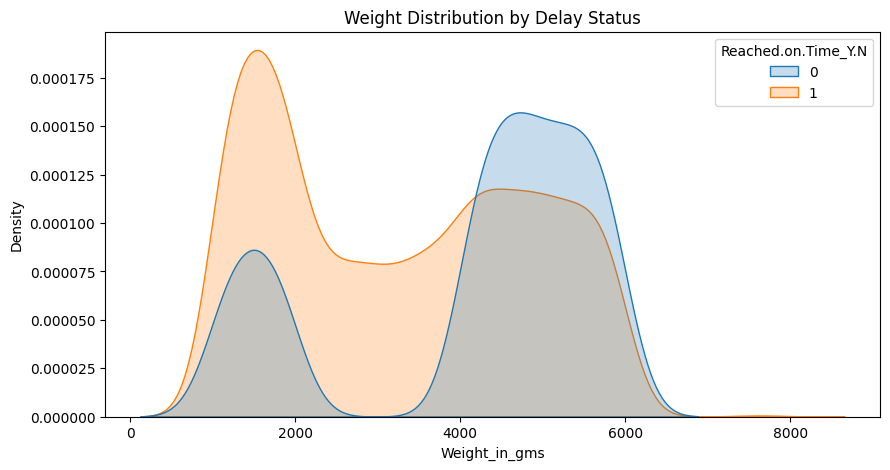

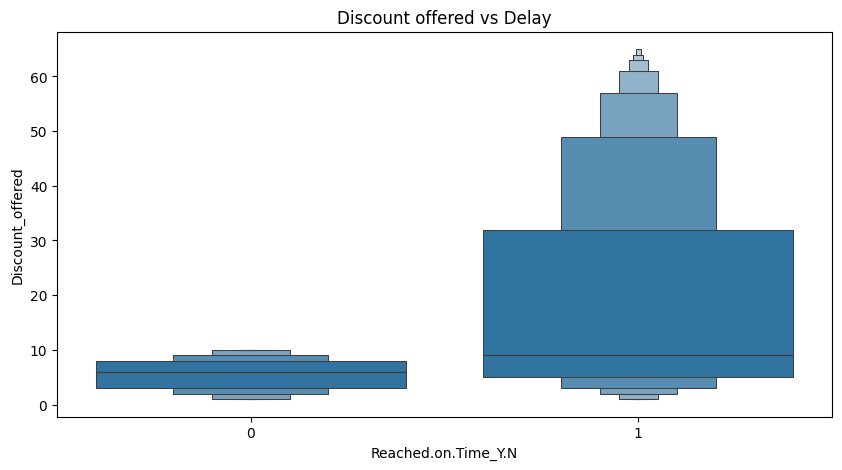

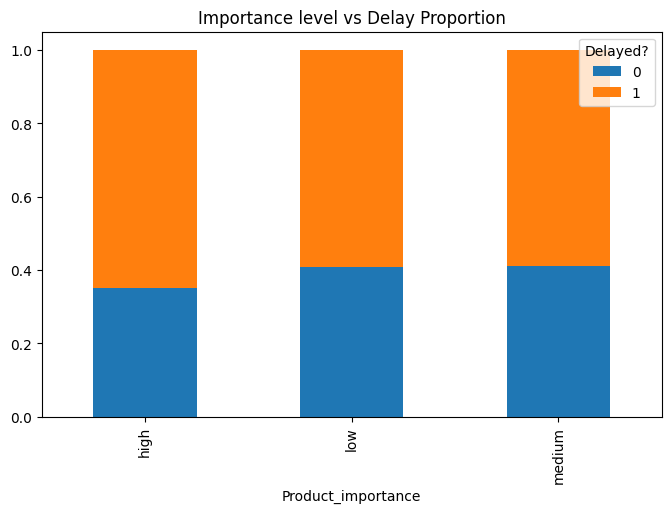

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 무게(Weight)와 지연의 관계 (KDE Plot)
# 곡선이 겹치지 않고 벌어지는 구간이 예측에 핵심적인 구간입니다.
plt.figure(figsize=(10, 5))
sns.kdeplot(data=train_df, x='Weight_in_gms', hue='Reached.on.Time_Y.N', fill=True)
plt.title("Weight Distribution by Delay Status")
plt.show()

# 2. 할인율(Discount)의 임계점 확인
# 어느 지점부터 지연 확률이 급격히 올라가는지 확인합니다.
plt.figure(figsize=(10, 5))
sns.boxenplot(x='Reached.on.Time_Y.N', y='Discount_offered', data=train_df)
plt.title("Discount offered vs Delay")
plt.show()

# 3. 제품 중요도(Product_importance)에 따른 지연 비중 (Stack Bar)
ct = pd.crosstab(train_df['Product_importance'], train_df['Reached.on.Time_Y.N'], normalize='index')
ct.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Importance level vs Delay Proportion")
plt.legend(title="Delayed?", loc='upper right')
plt.show()

In [13]:
# 파생변수 생성
train_df['Discount10'] = (train_df['Discount_offered'] > 10).astype(int)
train_df['Weight_log'] = np.log1p(train_df['Weight_in_gms'])
train_df['BlockMode'] = train_df['Warehouse_block'].astype(str) + '_' + train_df['Mode_of_Shipment'].astype(str)
train_df['Weight_Level'] = pd.cut(train_df['Weight_in_gms'], 
                            bins=[0, 2000, 4000, 10000], 
                            labels=[0, 1, 2]).astype(int)

# train_df.info()

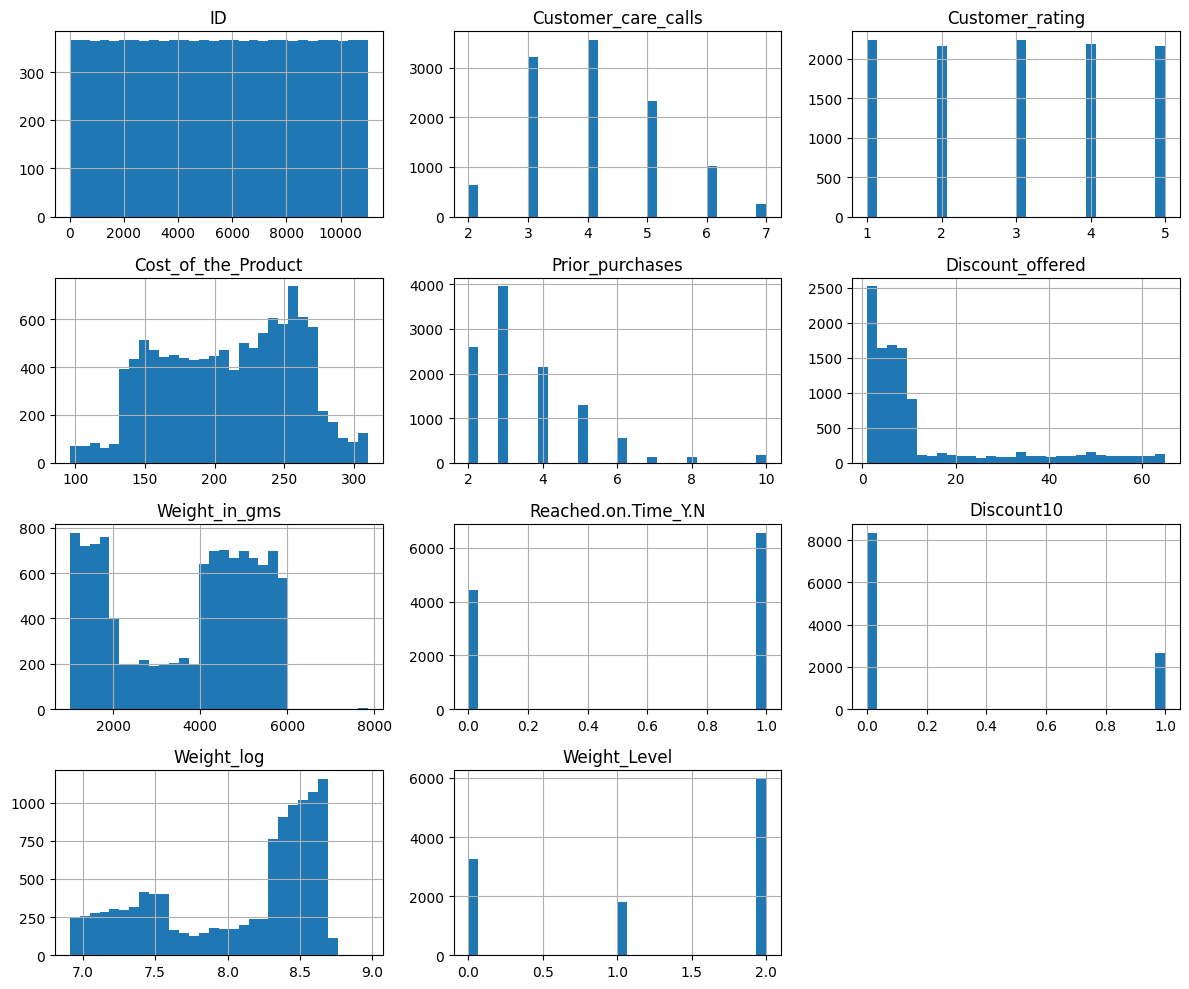

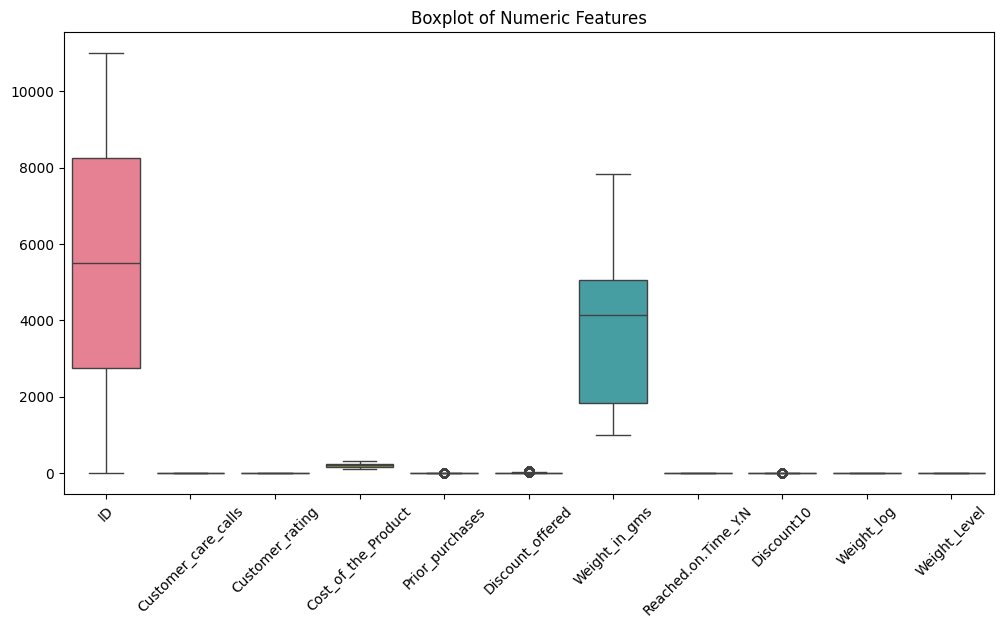

In [14]:
# 수치형 변수만 선택
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# 히스토그램으로 분포 확인
train_df[numeric_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# 박스플롯으로 이상치 확인
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[numeric_cols])
plt.xticks(rotation=45)
plt.title('Boxplot of Numeric Features')
plt.show()

In [15]:
# 수치형 변환
labelEn = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'BlockMode']:
    train_df[col] = labelEn.fit_transform(train_df[col].astype(str))

# train_df.head()

# 모델링에 사용할 컬럼 선택
columns = ['Discount10', 'Weight_log', 'BlockMode', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Discount_offered', 'Weight_Level']

X = train_df[columns]
y = train_df['Reached.on.Time_Y.N']

In [16]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# 데이터 불균형 처리
smote = SMOTE(random_state = 42)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)

# 모델링
# CatBoost, LightGBM, XGBoost 세 개 써보고 앙상블까지 다 했는데 Catboost가 가장 좋았음
cat_model = CatBoostClassifier(
    iterations = 500,
    learning_rate = 0.05,
    depth = 6,
    eval_metric = 'AUC',
    random_seed = 42,
    verbose = 100 
)

cat_model.fit(X_train_smt, y_train_smt, eval_set = (X_test, y_test))

0:	test: 0.7351629	best: 0.7351629 (0)	total: 146ms	remaining: 1m 12s
100:	test: 0.7421548	best: 0.7531999 (8)	total: 674ms	remaining: 2.66s
200:	test: 0.7389577	best: 0.7531999 (8)	total: 1.2s	remaining: 1.78s
300:	test: 0.7358142	best: 0.7531999 (8)	total: 1.7s	remaining: 1.13s
400:	test: 0.7375564	best: 0.7531999 (8)	total: 2.2s	remaining: 544ms
499:	test: 0.7387756	best: 0.7531999 (8)	total: 2.72s	remaining: 0us

bestTest = 0.7531999406
bestIteration = 8

Shrink model to first 9 iterations.


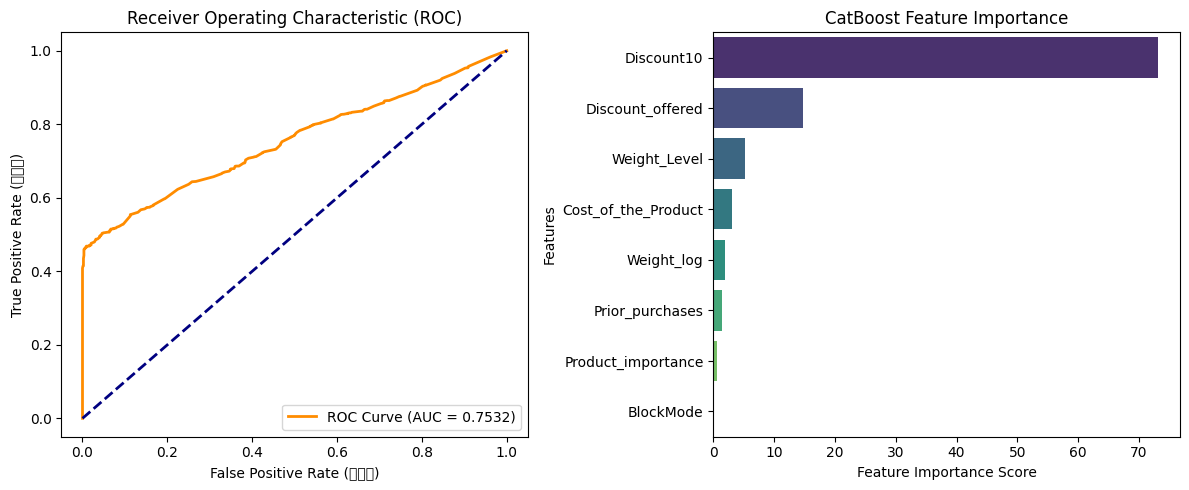

In [17]:
# 1. ROC 커브 시각화 (모델의 변별력 확인)
y_probs = cat_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(12, 5))

# 첫 번째 그래프: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (실수율)')
plt.ylabel('True Positive Rate (재현율)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# 2. 변수 중요도 시각화 (어떤 변수가 지연에 큰 영향을 줬나?)
plt.subplot(1, 2, 2)
# CatBoost에서 중요도 가져오기
importances = cat_model.get_feature_importance()
feature_names = X_train.columns
feature_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. 모델 예측 (이미 모델 학습이 완료된 상태여야 합니다)
y_pred = cat_model.predict(X_test)      # 0 또는 1로 예측
y_probs = cat_model.predict_proba(X_test)[:, 1] # 확률값으로 예측

# 2. 결과 출력
print("--- [모델 성능 평가 보고서] ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_probs):.4f}")
print("\n[상세 분류 보고서]")
print(classification_report(y_test, y_pred))

--- [모델 성능 평가 보고서] ---
Accuracy : 0.6786
ROC-AUC  : 0.7532

[상세 분류 보고서]
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       887
           1       0.99      0.47      0.64      1313

    accuracy                           0.68      2200
   macro avg       0.77      0.73      0.67      2200
weighted avg       0.81      0.68      0.67      2200

